## Lensed source injection in DC2 data

This notebook uses sim-pipeline to generate lens-deflector population. Then, we select a random lens-deflector and inject it to a patch of the DC2 data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Generate population of sources and deflectors

Using sim-pipeline one can generate galaxy-galaxy lenses.

In [2]:
import sys
sys.path.insert(0, '/home/nkhadka/notebooks/mytutorials/sim-pipeline/')

In [3]:
# define a cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
from astropy.units import Quantity
sky_area = Quantity(value=0.1, unit='deg2')


# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {'band': 'g', 'band_max':28, 'z_min': 0.01, 'z_max': 2.5}
kwargs_source_cut = {'band': 'g', 'band_max':28, 'z_min': 0.1, 'z_max': 5.}

# import GGLensPop class
from sim_pipeline.gg_lens_pop import GGLensPop
# run skypy pipeline and make galaxy-galaxy population class
gg_lens_pop = GGLensPop(lens_type='all-galaxies', source_type='galaxies', 
                        kwargs_deflector_cut=kwargs_deflector_cut, kwargs_source_cut=kwargs_source_cut,
                        kwargs_mass2light=None, skypy_config=None, sky_area=sky_area, cosmo=cosmo)

## Select a lens at random and generate a high resolution image

In [4]:
from sim_pipeline.image_simulation import sharp_image, sharp_rgb_image, rgb_image_from_image_list

In [5]:
kwargs_lens_cut={'min_image_separation': 0.8, 'max_image_separation': 10, 'mag_arc_limit': {'g': 23, 'r': 23, 'i': 23}}
rgb_band_list=['i', 'r', 'g']
lens_class = gg_lens_pop.select_lens_at_random(**kwargs_lens_cut)

In [17]:
#print(lens_class.einstein_radius)
#print(lens_class.deflector_velocity_dispersion())
#print(lens_class.deflector_stellar_mass())
#print(lens_class.einstein_radius)
#print(lens_class.lens_redshift)
#print(lens_class.source_redshift)
#print(lens_class.source_magnitude(band='g', lensed=True))
#print(lens_class.deflector_magnitude(band='g'))

In [18]:
image_i_1 = sharp_image(lens_class=lens_class, band=rgb_band_list[0], mag_zero_point=27, delta_pix=0.2, num_pix=200)
image_r_1 = sharp_image(lens_class=lens_class, band=rgb_band_list[1], mag_zero_point=27, delta_pix=0.2, num_pix=200)
image_g_1 = sharp_image(lens_class=lens_class, band=rgb_band_list[2], mag_zero_point=27, delta_pix=0.2, num_pix=200)

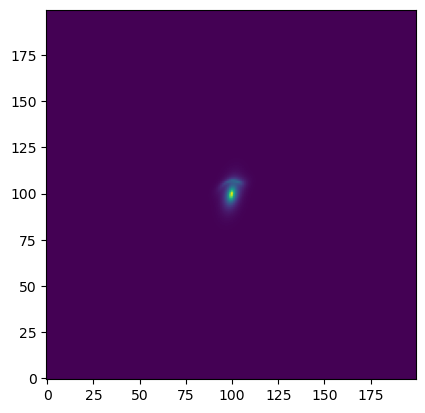

In [19]:
#image_g.shape
plt.imshow(image_r_1, origin='lower')

In [20]:
high_reso_rgb=sharp_rgb_image(lens_class=lens_class, rgb_band_list=rgb_band_list, mag_zero_point=27, delta_pix=0.2, num_pix=200)

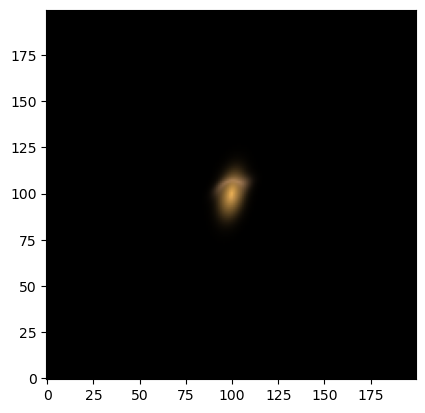

In [21]:
plt.imshow(high_reso_rgb, origin='lower')

## Initiation of Butler

Here we initiate butler and take a cutout of the DC2 data where we inject randomly selected lens.

In [22]:
from sim_pipeline.image_simulation import gsobj, gsobj_test
gsobj_r=gsobj_test(image_r_1, pix_scale=0.2)
gsobj_g=gsobj_test(image_g_1, pix_scale=0.2)
gsobj_i=gsobj_test(image_i_1, pix_scale=0.2)

In [4]:
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import (FixedLocator, MaxNLocator,
                                                 DictFormatter)
from matplotlib.transforms import Affine2D
import pickle
import pandas as pd
%matplotlib inline

import lsst.daf.butler as dafButler
import lsst.geom as geom
import lsst.afw.display as afwDisplay
# Source injection
from lsst.pipe.tasks.insertFakes import _add_fake_sources

In [5]:
config = "dp02"
collection ='2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get("skyMap")

# Near the center of DC2
ra = 62.541629   # degrees
dec = -37.852021 # degrees
point = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(201, 201)
#print(cutoutSize)


#Read this from the table we have at hand... 
tractInfo = skymap.findTract(point)
patchInfo = tractInfo.findPatch(point)
my_tract = tractInfo.tract_id
my_patch = patchInfo.getSequentialIndex()

xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))

bbox = geom.BoxI(xy + cutoutSize//2, cutoutSize)

coaddId_r = {
    'tract':my_tract, 
    'patch':my_patch,
    'band':'i'
}
coadd = butler.get("deepCoadd", dataId=coaddId_r)
coadd_cut_r = butler.get("deepCoadd",parameters={'bbox':bbox}, dataId=coaddId_r)

'# Near the center of DC2\nra = 62.541629   # degrees\ndec = -37.852021 # degrees\npoint = geom.SpherePoint(ra, dec, geom.degrees)\ncutoutSize = geom.ExtentI(201, 201)\n#print(cutoutSize)\n\n\n#Read this from the table we have at hand... \ntractInfo = skymap.findTract(point)\npatchInfo = tractInfo.findPatch(point)\nmy_tract = tractInfo.tract_id\nmy_patch = patchInfo.getSequentialIndex()\n\nxy = geom.PointI(tractInfo.getWcs().skyToPixel(point))\n\nbbox = geom.BoxI(xy + cutoutSize//2, cutoutSize)\n\ncoaddId_r = {\n    \'tract\':my_tract, \n    \'patch\':my_patch,\n    \'band\':\'i\'\n}\ncoadd = butler.get("deepCoadd", dataId=coaddId_r)\ncoadd_cut_r = butler.get("deepCoadd",parameters={\'bbox\':bbox}, dataId=coaddId_r)'

In [32]:
coaddId_g = {
    'tract':3638, 
    'patch':27,
    'band':'g'
}
coaddId_i = {
    'tract':3638, 
    'patch':27,
    'band':'i'
}
coadd_cut_g = butler.get("deepCoadd",parameters={'bbox':bbox}, dataId=coaddId_g)
coadd_cut_i = butler.get("deepCoadd",parameters={'bbox':bbox}, dataId=coaddId_i)

In [27]:
afwDisplay.setDefaultBackend('matplotlib')

(23899.5, 27999.5, 11899.5, 16099.5)

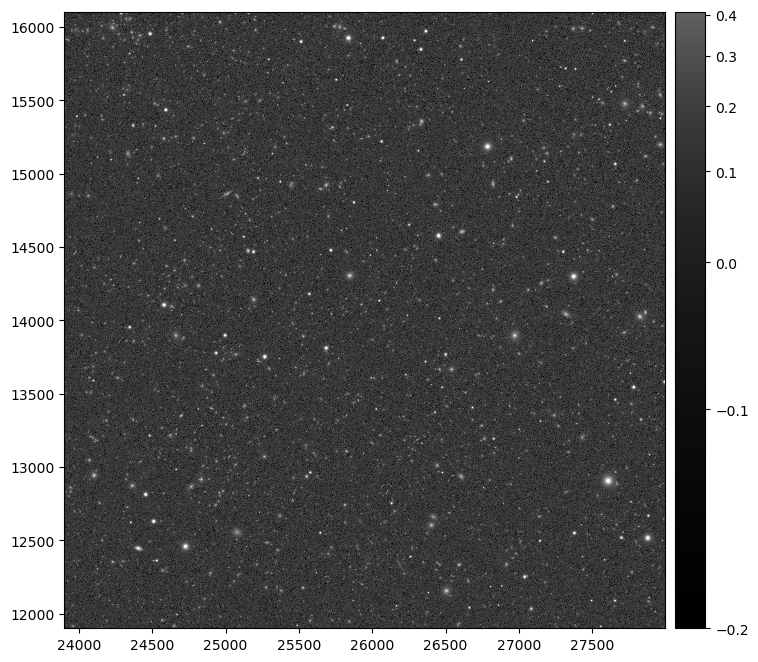

In [28]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(coadd.image)
plt.gca().axis('on')

## Cutout from the DC2 data

(26578.5, 26779.5, 15513.5, 15714.5)

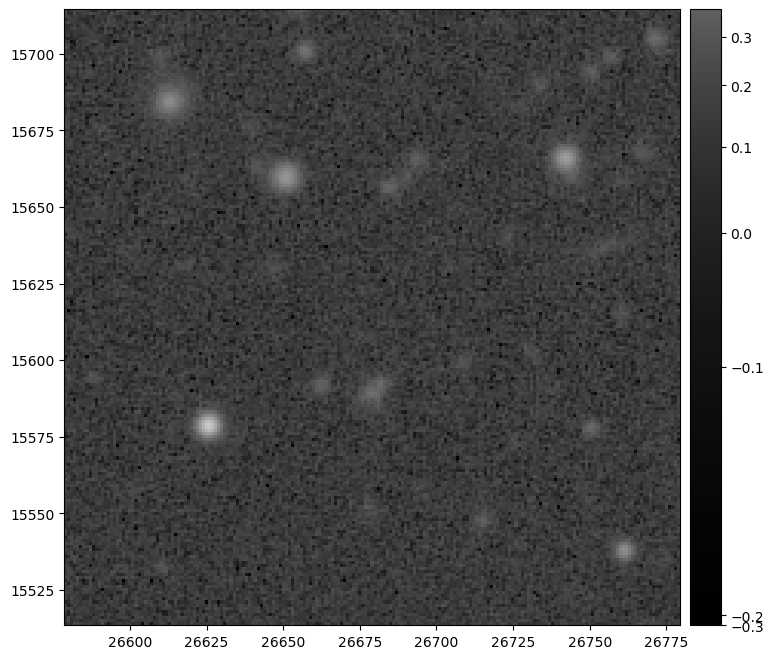

In [29]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(coadd_cut_r.image)
plt.gca().axis('on')

## Inject the randomly selected lens (we have already selected a lens above).

## 1. r band

(62.5277017829, -37.8407981636)
(62.5416290000, -37.8520210000)


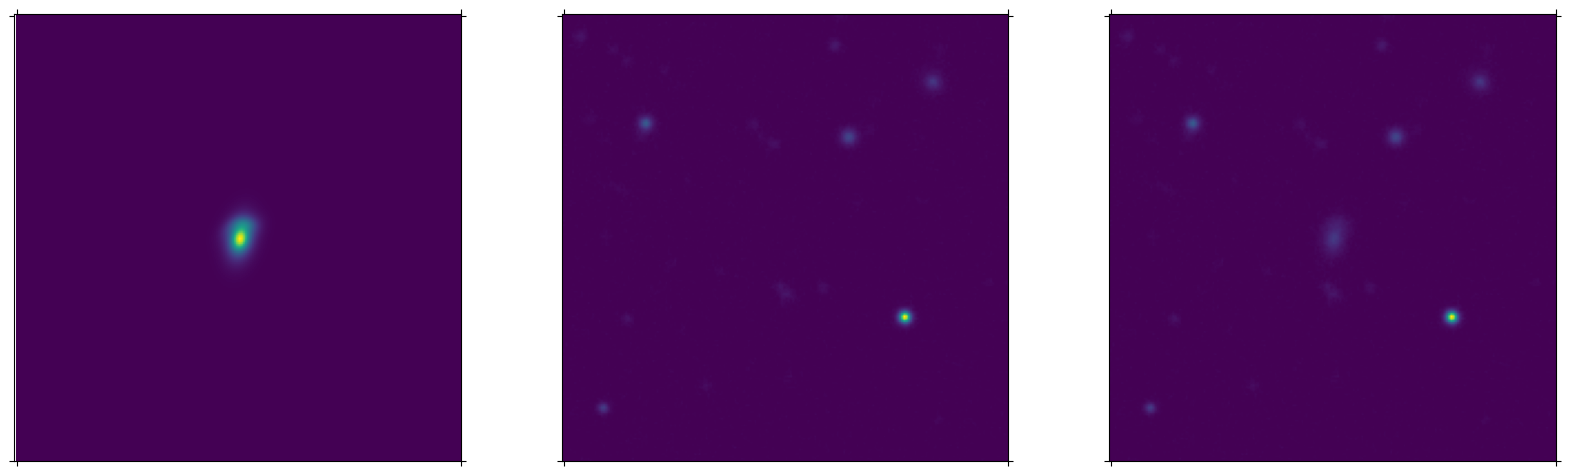

In [34]:
wcs_r= coadd_cut_r.getWcs()
bbox_r= coadd_cut_r.getBBox()
x_min_r = bbox_r.getMinX()
y_min_r = bbox_r.getMinY()
x_max_r = bbox_r.getMaxX()
y_max_r = bbox_r.getMaxY()

# Calculate the center coordinates
x_center_r = (x_min_r + x_max_r) / 2
y_center_r = (y_min_r + y_max_r) / 2

center_r = geom.Point2D(x_center_r, y_center_r)
#geom.Point2D(26679, 15614)
point_r=wcs_r.pixelToSky(center_r)
print(point_r)

image_r = butler.get("deepCoadd", parameters={'bbox':bbox_r}, dataId=coaddId_r)
mat = np.eye(3)
mat[:2,:2] = wcs_r.getCdMatrix()

transform = Affine2D(mat)
fig = plt.figure(figsize=(20, 18))
arr_r = np.copy(image_r.image.array)
plot_extents = 0, bbox.width, 0, bbox.height
helper = floating_axes.GridHelperCurveLinear(
    transform, plot_extents, 
    tick_formatter1=DictFormatter({}),
    tick_formatter2=DictFormatter({}),
    grid_locator1=MaxNLocator(nbins=1),
    grid_locator2=MaxNLocator(nbins=1),

)
ax = floating_axes.FloatingSubplot(fig, 132, grid_helper=helper)
ax.imshow((arr_r), vmin=0, transform=transform+ax.transData, origin='lower')
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)
print(point)
_add_fake_sources(image_r, [(point_r, gsobj_r)])
inj_arr_r = image_r.image.array
plot_extents = 0, bbox.width, 0, bbox.height
helper = floating_axes.GridHelperCurveLinear(
    transform, plot_extents, 
    tick_formatter1=DictFormatter({}),
    tick_formatter2=DictFormatter({}),
    grid_locator1=MaxNLocator(nbins=1),
    grid_locator2=MaxNLocator(nbins=1),
)
ax = floating_axes.FloatingSubplot(fig, 133, grid_helper=helper)
ax.imshow((inj_arr_r), vmin=0, transform=transform+ax.transData, origin='lower')
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)

ax = floating_axes.FloatingSubplot(fig, 131, grid_helper=helper)
ax.imshow((inj_arr_r-arr_r), vmin=0, transform=transform+ax.transData, origin='lower')
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)
#fig.suptitle(repr(coaddId))
fig.show()

## 2. g band

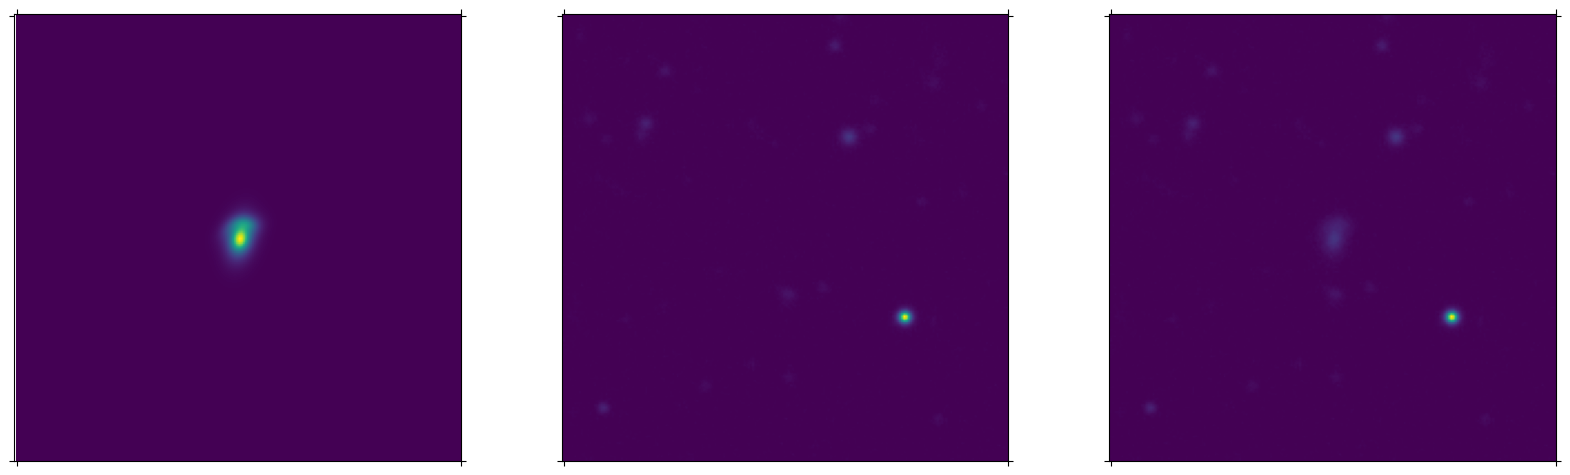

In [35]:
wcs_g= coadd_cut_g.getWcs()
bbox_g= coadd_cut_g.getBBox()
image_g = butler.get("deepCoadd", parameters={'bbox':bbox_g}, dataId=coaddId_g)
mat = np.eye(3)
mat[:2,:2] = wcs_g.getCdMatrix()
transform = Affine2D(mat)
fig = plt.figure(figsize=(20, 18))
arr_g = np.copy(image_g.image.array)
plot_extents = 0, bbox.width, 0, bbox.height
helper = floating_axes.GridHelperCurveLinear(
    transform, plot_extents, 
    tick_formatter1=DictFormatter({}),
    tick_formatter2=DictFormatter({}),
    grid_locator1=MaxNLocator(nbins=1),
    grid_locator2=MaxNLocator(nbins=1),

)
ax = floating_axes.FloatingSubplot(fig, 132, grid_helper=helper)
ax.imshow((arr_g), vmin=0, transform=transform+ax.transData)
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)
_add_fake_sources(image_g, [(point_r, gsobj_g)])
inj_arr_g = image_g.image.array
plot_extents = 0, bbox.width, 0, bbox.height
helper = floating_axes.GridHelperCurveLinear(
    transform, plot_extents, 
    tick_formatter1=DictFormatter({}),
    tick_formatter2=DictFormatter({}),
    grid_locator1=MaxNLocator(nbins=1),
    grid_locator2=MaxNLocator(nbins=1),
)
ax = floating_axes.FloatingSubplot(fig, 133, grid_helper=helper)
ax.imshow((inj_arr_g), vmin=0, transform=transform+ax.transData)
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)

ax = floating_axes.FloatingSubplot(fig, 131, grid_helper=helper)
ax.imshow((inj_arr_g-arr_g), vmin=0, transform=transform+ax.transData)
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)
#fig.suptitle(repr(coaddId))
fig.show()

## 3. i band

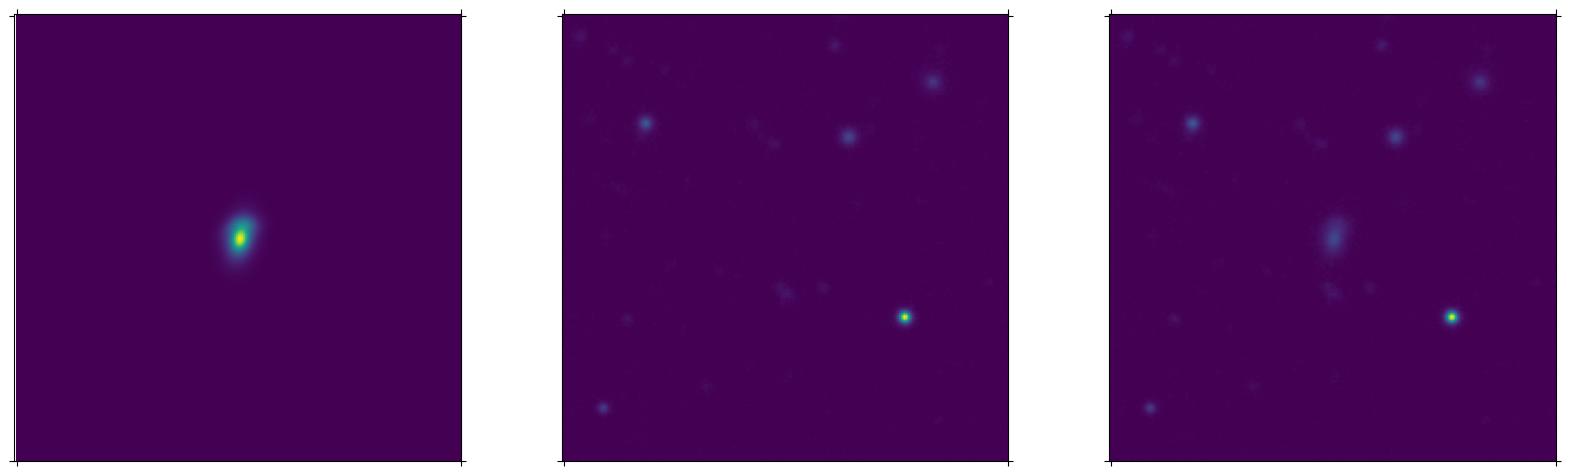

In [36]:
wcs_i= coadd_cut_i.getWcs()
bbox_i= coadd_cut_i.getBBox()
image_i = butler.get("deepCoadd", parameters={'bbox':bbox_i}, dataId=coaddId_i)
mat = np.eye(3)
mat[:2,:2] = wcs_i.getCdMatrix()
transform = Affine2D(mat)
fig = plt.figure(figsize=(20, 18))
arr_i = np.copy(image_i.image.array)
plot_extents = 0, bbox.width, 0, bbox.height
helper = floating_axes.GridHelperCurveLinear(
    transform, plot_extents, 
    tick_formatter1=DictFormatter({}),
    tick_formatter2=DictFormatter({}),
    grid_locator1=MaxNLocator(nbins=1),
    grid_locator2=MaxNLocator(nbins=1),

)
ax = floating_axes.FloatingSubplot(fig, 132, grid_helper=helper)
ax.imshow((arr_i), vmin=0, transform=transform+ax.transData)
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)
_add_fake_sources(image_i, [(point_r, gsobj_i)])
inj_arr_i = image_i.image.array
plot_extents = 0, bbox_i.width, 0, bbox_i.height
helper = floating_axes.GridHelperCurveLinear(
    transform, plot_extents, 
    tick_formatter1=DictFormatter({}),
    tick_formatter2=DictFormatter({}),
    grid_locator1=MaxNLocator(nbins=1),
    grid_locator2=MaxNLocator(nbins=1),
)
ax = floating_axes.FloatingSubplot(fig, 133, grid_helper=helper)
ax.imshow((inj_arr_i), vmin=0, transform=transform+ax.transData)
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)

ax = floating_axes.FloatingSubplot(fig, 131, grid_helper=helper)
ax.imshow((inj_arr_i-arr_i), vmin=0, transform=transform+ax.transData)
"""ax.scatter(
    xy.x - bbox.minX, 
    xy.y - bbox.minY, 
    c='r', marker='+', transform=transform+ax.transData
)"""
fig.add_subplot(ax)
#fig.suptitle(repr(coaddId))
fig.show()

## Create rgb images

In [37]:
image_list=[inj_arr_i, inj_arr_r, inj_arr_g]
image_list_1=[arr_i, arr_r, arr_g]
final_injected_image=rgb_image_from_image_list(image_list=image_list, stretch=2)
final_uninjected_image=rgb_image_from_image_list(image_list=image_list_1, stretch=2)

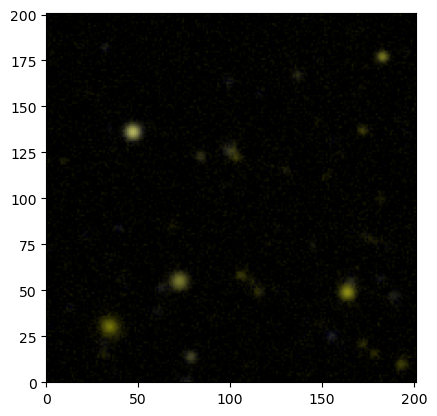

In [38]:
plt.imshow(final_uninjected_image, extent = [0, bbox.width, 0, bbox.height])

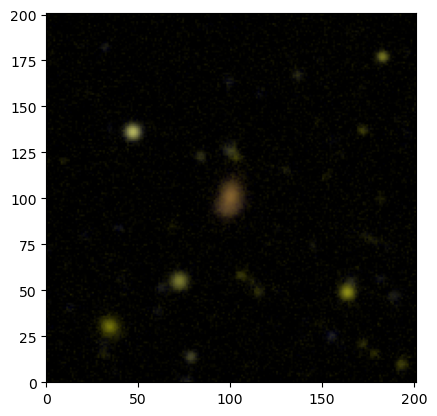

In [39]:
plt.imshow(final_injected_image,extent = [0, bbox.width, 0, bbox.height])

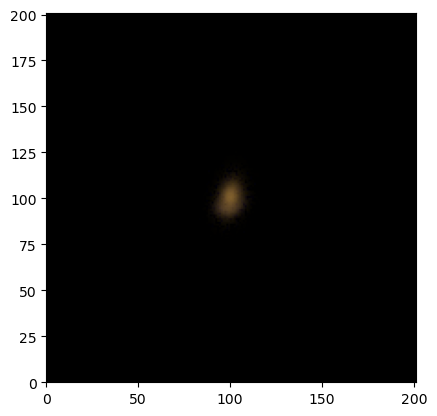

In [40]:
plt.imshow(final_injected_image-final_uninjected_image, extent = [0, bbox.width, 0, bbox.height])

## Instead all above process, one can simply call RSP module from sim-pipeline and do all aove process

In [6]:
from sim_pipeline import RSP

In [7]:
ra = 62.541629   # degrees
dec = -37.852021 # degrees

In [8]:
y=RSP.lens_inejection(gg_lens_pop, ra, dec, 201, 0.2, butler, flux=None)

In [9]:
y

lens_r,lens_g,lens_i,cutout_center
"float32[201,201]","float32[201,201]","float32[201,201]",float64[2]
-0.026971897 .. -0.07698938,-0.0094911335 .. -0.024472523,-0.06584367 .. 0.063346915,62.52770178285992 .. -37.84079816363484
